regular bayes between 20-2000

In [ ]:
# General
import numpy as np
import pandas as pd
import os, sys
import optuna
from datetime import datetime

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rcParams["text.usetex"] = False


# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

#sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
from feature_set_v2 import MergedDataLoader 




In [2]:
# ---------------------------------------------------------------------
# 1) Purged/embargoed window function
# ---------------------------------------------------------------------
def get_train_val_windows(
        current_date, 
        full_data, 
        min_train_years=8,
        max_train_years=12, 
        val_years=3,
        initial_train_start=None,
        gap_days=3                                      # gap_days: number of days to exclude at the train/validation boundary (purge/embargo) to avoid look‑ahead; set to 0 to disable
    ):
    # 1) Validation window
    val_end   = current_date
    val_start = val_end - pd.DateOffset(years=val_years)
    
    # 2) Train ends just before validation
    train_end = val_start - pd.DateOffset(days=1)
    
    # 3) Max‐length training start
    train_start_candidate = train_end - pd.DateOffset(years=max_train_years)
    if initial_train_start is not None:
        earliest = pd.to_datetime(initial_train_start)
        train_start_candidate = max(train_start_candidate, earliest)
    
    # 4) Enforce min‐length
    if (train_end - train_start_candidate) < pd.Timedelta(days=365.25 * min_train_years):
        train_start_candidate = train_end - pd.DateOffset(years=min_train_years)
        if initial_train_start is not None:
            train_start_candidate = max(train_start_candidate, earliest)
    
    idx       = full_data.index
    train_idx = idx[(idx >= train_start_candidate) & (idx <= train_end)]
    val_idx   = idx[(idx >= val_start)           & (idx <= val_end)]
    
    # 5) Purge/embargo
    if gap_days > 0:
        if len(train_idx) > gap_days:
            train_idx = train_idx[:-gap_days]
        if len(val_idx)   > gap_days:
            val_idx   = val_idx[gap_days:]
    
    if train_idx.empty or val_idx.empty:
        raise ValueError(
            f"No data for train [{train_start_candidate.date()}-{train_end.date()}] "
            f"or val [{val_start.date()}-{val_end.date()}] after {gap_days}-day gap"
        )
    
    return train_idx[0], train_idx[-1], val_idx[0], val_idx[-1]


# ---------------------------------------------------------------------
# 2) Optuna objective & wrapper
# ---------------------------------------------------------------------
# 1) New evaluator that fits one model & returns Sharpe:
def evaluate_sjm_sharpe(
    lam, kappa,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    # online predict & PnL exactly as before:
    val_states = model.predict_online(X_vl_s)
    pnl = np.zeros(len(val_states))
    prev_pos = 0.0
    for t in range(len(val_states)):
        st = val_states.iloc[t]
        exp_ann = model.ret_[st] * 252
        # position rule:
        if exp_ann > annual_threshold: pos = 1.0
        elif exp_ann < -annual_threshold: pos = -1.0
        else: pos = exp_ann/annual_threshold
        pnl[t] = prev_pos * ar_vl.iloc[t] - abs(pos-prev_pos)*cost_per_100pct
        prev_pos = pos
    sharpe = pnl.mean()/pnl.std(ddof=1)*np.sqrt(252)
    return sharpe

# 2) Rewrite your Optuna objective to use it:
def optuna_objective(
    trial,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    lam   = trial.suggest_float("lambda", 10**1.3, 10**3.3)
    kappa = trial.suggest_int("kappa", 1, np.sqrt(17))
    return evaluate_sjm_sharpe(
        lam, kappa,
        X_tr_s, X_vl_s,
        ar_tr, ar_vl,
        cost_per_100pct, annual_threshold
    )

# 3) In your Bayesian wrapper, return the study:
def bayesian_hyperparam_search(
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct=0.0005,
    annual_threshold=0.05,
    n_trials=30
):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
    study.optimize(
        lambda t: optuna_objective(
            t, X_tr_s, X_vl_s, ar_tr, ar_vl,
            cost_per_100pct, annual_threshold
        ),
        n_trials=n_trials
    )
    return study


# ---------------------------------------------------------------------
# 3) Rolling CV + final‑model fit using Optuna
# ---------------------------------------------------------------------
def rolling_time_series_cv_sjm_long_short_optimized(
    X_train, X_val,
    factor_returns_train, factor_returns_val,
    market_returns_train, market_returns_val,
    cost_per_100pct=0.0005,
    annual_threshold=0.05,
    n_trials=30
):
    # --- align indices & build active returns ---
    tr_idx = X_train.index.intersection(factor_returns_train.index).intersection(market_returns_train.index)
    vl_idx = X_val.index.intersection(factor_returns_val.index).intersection(market_returns_val.index)
    
    X_tr = X_train.loc[tr_idx]
    X_vl = X_val.loc[vl_idx]
    ar_tr = factor_returns_train.loc[tr_idx] - market_returns_train.loc[tr_idx]
    ar_vl = factor_returns_val.loc[vl_idx]     - market_returns_val.loc[vl_idx]
    
    # --- preprocess ---
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    
    X_tr_s = pd.DataFrame(
        scaler.fit_transform(clipper.fit_transform(X_tr)),
        index=X_tr.index, columns=X_tr.columns
    )
    X_vl_s = pd.DataFrame(
        scaler.transform(clipper.transform(X_vl)),
        index=X_vl.index, columns=X_vl.columns
    )
    
    # --- Bayesian search ---
    study = bayesian_hyperparam_search(
        X_tr_s, X_vl_s, ar_tr, ar_vl,
        cost_per_100pct, annual_threshold,
        n_trials
    )
    lam, kappa = study.best_params["lambda"], study.best_params["kappa"]
    best_sharpe = study.best_value
    print(f"Optuna best λ={lam:.4f}, κ={kappa}, Sharpe={best_sharpe:.4f}")
    
    # --- fit final SJM on the full train window ---
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    
    return {
        "best_lambda": lam,
        "best_kappa":  kappa,
        "best_sharpe": best_sharpe,
        "best_model":  model,
        "results_array": None,
        "study": study
    }

In [ ]:
# ---------------------------------------------------------------------
# 4) Updated cross‑validation module (run_cv)
# ---------------------------------------------------------------------
def run_cv(
    factors,
    factor_data_dict,
    cv_dates,
    *,
    min_train_years=8,
    max_train_years=12,
    val_years=3,
    initial_train_start=None,
    save_path="cv_params_bayes_20-2000.parquet",
    make_plots=True,
    cost_per_100pct=0.0005,
    annual_threshold=0.05,
    n_trials=30
):
    
    # --- Create timestamped output folder ---
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = f"cv_bayes_output_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # --- Prepare logging ---
    log_path = os.path.join(output_dir, "output_log.txt")
    original_stdout = sys.stdout
    sys.stdout = open(log_path, "w")

    records = []
    evolution_plotbuf = []

    for cv_end in cv_dates:
        for fac in factors:
            X       = factor_data_dict[fac]["X"]
            fac_ret = factor_data_dict[fac]["fac_ret"]
            mkt_ret = factor_data_dict[fac]["mkt_ret"]

            # get purged train/val windows
            train_start, train_end, val_start, val_end = get_train_val_windows(
                cv_end, X,
                min_train_years=min_train_years,
                max_train_years=max_train_years,
                val_years=val_years,
                initial_train_start=initial_train_start,
                gap_days=3
            )

            # slice data
            X_train  = filter_date_range(X, train_start, train_end)
            X_val    = filter_date_range(X, val_start,   val_end)
            fr_train = filter_date_range(fac_ret, train_start, train_end)
            fr_val   = filter_date_range(fac_ret, val_start,   val_end)
            mr_train = filter_date_range(mkt_ret, train_start, train_end)
            mr_val   = filter_date_range(mkt_ret, val_start,   val_end)

            # run Optuna‐powered CV
            res = rolling_time_series_cv_sjm_long_short_optimized(
                X_train=X_train,
                X_val=X_val,
                factor_returns_train=fr_train,
                factor_returns_val=fr_val,
                market_returns_train=mr_train,
                market_returns_val=mr_val,
                cost_per_100pct=cost_per_100pct,
                annual_threshold=annual_threshold,
                n_trials=n_trials
            )

            # store results
            records.append({
                "date": cv_end,
                "factor": fac,
                "best_lambda": res["best_lambda"],
                "best_kappa":  res["best_kappa"]
            })
            evolution_plotbuf.append({
                "date": cv_end,
                "factor": fac,
                "lambda": res["best_lambda"],
                "kappa":  res["best_kappa"]
            })

            # per‐fold Optuna scatter plot
            if make_plots:
                trials = res["study"].trials
                df_t = pd.DataFrame([
                    {"lambda": t.params["lambda"],
                     "kappa":  t.params["kappa"],
                     "value":  t.value}
                    for t in trials
                ])
                plt.figure(figsize=(8,5))
                sc = plt.scatter(
                    df_t["lambda"],
                    df_t["value"],
                    c=df_t["kappa"].astype(float),
                    cmap="viridis",
                    alpha=0.8
                )
                plt.xscale("log")
                plt.axvline(res["best_lambda"], ls="--", c="r", alpha=0.6)
                plt.colorbar(sc, label='$\\kappa$')
                plt.xlabel("'$\\lambda$' (log scale)")
                plt.ylabel("Validation Sharpe")
                plt.title(f"{fac} | CV cutoff {cv_end.date()} - Optuna trials")
                plt.grid(True, ls=":")
                plt.tight_layout()
                plt.show()

    # assemble and save
    cv_df = pd.DataFrame(records).sort_values(["factor", "date"])
    if save_path:
        cv_df.to_parquet(save_path)

    # overall λ/κ evolution
    if make_plots:
        evo = pd.DataFrame(evolution_plotbuf)
        for fac in factors:
            sub = evo[evo["factor"] == fac].sort_values("date")
            fig, ax1 = plt.subplots(figsize=(9,5))
            ax1.plot(sub["date"], sub["lambda"], marker="o", label='$\\lambda$')
            ax1.set_ylabel('$\\lambda$', color="tab:blue")
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax2 = ax1.twinx()
            ax2.plot(sub["date"], sub["kappa"], marker="x", ls="--", color="tab:red", label='$\\kappa$')
            ax2.set_ylabel('$\\kappa$', color="tab:red")
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax1.set_xlabel("CV end-date")
            ax1.set_title(f"{fac} — hyperparameter evolution")
            ax1.grid(True, ls=":")
            ax1.legend(loc="upper left")
            ax2.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

    return cv_df


[I 2025-04-26 08:57:45,545] A new study created in memory with name: no-name-e459080a-1b65-4b22-bdc1-eb44224d458b
[I 2025-04-26 08:57:46,868] Trial 0 finished with value: 0.05995829038622425 and parameters: {'lambda': 759.7853498839952, 'kappa': 4}. Best is trial 0 with value: 0.05995829038622425.
[I 2025-04-26 08:57:47,376] Trial 1 finished with value: 0.05995829038622425 and parameters: {'lambda': 1465.8673507626895, 'kappa': 3}. Best is trial 0 with value: 0.05995829038622425.
[I 2025-04-26 08:57:49,212] Trial 2 finished with value: -0.331840150097618 and parameters: {'lambda': 328.1377557200871, 'kappa': 1}. Best is trial 0 with value: 0.05995829038622425.
[I 2025-04-26 08:57:53,515] Trial 3 finished with value: 0.175393187318902 and parameters: {'lambda': 134.68574520140024, 'kappa': 4}. Best is trial 3 with value: 0.175393187318902.
[I 2025-04-26 08:57:54,035] Trial 4 finished with value: 0.05995829038622425 and parameters: {'lambda': 1207.3409317440555, 'kappa': 3}. Best is tria

Optuna best λ=134.6857, κ=4, Sharpe=0.1754


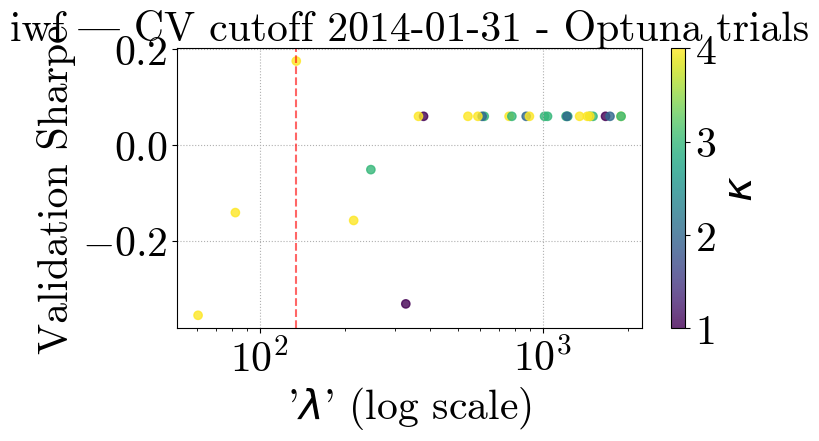

[I 2025-04-26 08:58:49,196] A new study created in memory with name: no-name-eed20732-9cca-4aba-85eb-5e49c158a4bc
[I 2025-04-26 08:58:51,752] Trial 0 finished with value: 0.7827096683047519 and parameters: {'lambda': 759.7853498839952, 'kappa': 4}. Best is trial 0 with value: 0.7827096683047519.
[I 2025-04-26 08:58:52,280] Trial 1 finished with value: 0.7827096683047515 and parameters: {'lambda': 1465.8673507626895, 'kappa': 3}. Best is trial 0 with value: 0.7827096683047519.
[I 2025-04-26 08:58:53,827] Trial 2 finished with value: 0.7827096683047519 and parameters: {'lambda': 328.1377557200871, 'kappa': 1}. Best is trial 0 with value: 0.7827096683047519.
[I 2025-04-26 08:58:57,587] Trial 3 finished with value: 0.6534307213293168 and parameters: {'lambda': 134.68574520140024, 'kappa': 4}. Best is trial 0 with value: 0.7827096683047519.
[I 2025-04-26 08:58:58,090] Trial 4 finished with value: 0.7827096683047515 and parameters: {'lambda': 1207.3409317440555, 'kappa': 3}. Best is trial 0 

KeyboardInterrupt: 

In [4]:
# -------------------------  QUICK STAND‑ALONE RUN  ----------------------- #
# ---- user‑specific setup (exactly as in your original script) -------- #

# Paths & tickers -----------------------------------------------------------------------
TEST_START       = "2014-01-01"
RECROSS_VAL_FREQ = "6ME"          # six‑month‑end


script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", ".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   

lambda_values = np.linspace(30, 400, 5)
# kappa grid can depend on feature count; a simple fixed grid is fine
kappa_values  = np.array([2.0, 3.0, 4.0]) # kappa = trial.suggest_int("kappa", 1, np.sqrt(17))

# ------- load full data into factor_data_dict here -------------------- #
# (use your existing MergedDataLoader logic)
factor_data_dict = {}
for fac in factors:
    data = MergedDataLoader(
                factor_file=factor_file,
                market_file=market_file,
                ver="v2",
                factor_col=fac).load()

    common_idx = (data.X.index
                    .intersection(data.ret_ser.index)
                    .intersection(data.market_ser.index))

    factor_data_dict[fac] = {
        "X":       data.X.loc[common_idx],
        "fac_ret": data.ret_ser.loc[common_idx],
        "mkt_ret": data.market_ser.loc[common_idx],
    }


master_index = factor_data_dict[factors[0]]["X"].index.sort_values()
test_index   = master_index[master_index >= TEST_START]

recross_val_boundaries = (
    test_index.to_series()
    .resample(RECROSS_VAL_FREQ)
    .last()
    .dropna()                     # Series of Timestamp objects
)
# ----------------------------------------------------------------------

cv_table = run_cv(
    factors,
    factor_data_dict,
    cv_dates=recross_val_boundaries,
    initial_train_start="2002-05-31"
)

print("Saved tuned parameters to cv_params.parquet")
print(cv_table.head())

In [ ]:
# # 1) Cast kappa to float
# cv_table["best_kappa"] = cv_table["best_kappa"].astype(float)

# # 2) (Optional) verify
# print(cv_table.dtypes)

# # 3) Save out
# cv_table.to_parquet("cv_params_bayes_v2.parquet", index=False) # v2 is the one searching from 0.1 to 1000


date           datetime64[ns]
factor                 object
best_lambda           float64
best_kappa            float64
dtype: object


In [5]:
with open("cell_output.txt", "w") as f:
    for r in records:  # or whatever your output list is
        f.write(str(r) + "\n")


NameError: name 'records' is not defined